# Birds Classification - Predictive Modelling Competition

This is a group done by Ya Ting Huang, Alexandra Landry, Nastasia Kantsevitch, and Julius Alessandro Xanthoudakis. 

The goal of this project was to use the Bird Species dataset from Kaggle to test our skills in image classification.

## Instructions for the Project:
    
Make sure that your Training, Validation AND Test sets contain the same classes of species

Your test set is to be used at the very end -- to get a good sense of how your model is performing

You are expected to compile a CNN in order to correctly classify your selected 15 classes

Google Colab is your friend - it can help boost your model's training time

It can be beneficial to reshape some of the images to reduce some of the data - this will help speed up your model's training time

Do some research to find out ways to help boost your model's performance (i.e. data augmentation)

Make sure to save your model and during the presentation you will load your model and evaluate its performance on the validation set

In [1]:
#Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

import PIL
from PIL import Image

import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers

#Pretrained model VGG
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16


#For InceptionV3 from Google
from tensorflow.keras import models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#pip install pyyaml h5py
#https://www.tensorflow.org/tutorials/keras/save_and_load

In [2]:
df = pd.read_csv('data//birds.csv')

In [3]:
df['labels'].value_counts().head(15) # Printing the first 15 bird species selected for the analysis

labels
RUFOUS TREPE             273
HOUSE FINCH              258
D-ARNAUDS BARBET         243
OVENBIRD                 243
ASIAN GREEN BEE EATER    230
SWINHOES PHEASANT        226
WOOD DUCK                224
CASPIAN TERN             223
RED BILLED TROPICBIRD    222
WOOD THRUSH              221
FRILL BACK PIGEON        219
PYRRHULOXIA              219
MERLIN                   219
ORNATE HAWK EAGLE        218
MILITARY MACAW           218
Name: count, dtype: int64

In [4]:
### Function to create the train, validation and test data to preprocess the images
def create_data(df, type_data):
    processed_data_directory = 'data/'
    data = []
    top_15 = df['labels'].value_counts().head(15).index.tolist()
    for c in top_15:
        image_folder = os.path.join(processed_data_directory + f'{type_data}/', c)
        for filename in os.listdir(image_folder):
            image_path = os.path.join(image_folder, filename)
            img = imread(image_path, as_gray=False)
            img = img / 255
            img = resize(img, (224, 224))
            class_value = top_15.index(c)
            data.append([img, class_value])
    return data

In [5]:
### Applying the create_data function to create the train, validation and test data
train_data = create_data(df, 'train')
valid_data = create_data(df, 'valid')
test_data = create_data(df, 'test')
print("Training data length:   ", len(train_data))
print("Validation data length: ", len(valid_data))
print("Testing data length:    ", len(test_data))

Training data length:    3306
Validation data length:  75
Testing data length:     75


In [6]:
### Shuffling our data around

train_data = shuffle(train_data)
valid_data = shuffle(valid_data)
test_data = shuffle(test_data)

In [7]:
### Splitting up our X and y for training, validation and testing sets

X_train = list()
y_train = list()
X_valid = list()
y_valid = list()
X_test = list()
y_test = list()

for attr, lbl in train_data:
    X_train.append(attr)
    y_train.append(lbl)
X_train = np.array(X_train)
y_train = np.array(y_train)

for attr, lbl in valid_data:
    X_valid.append(attr)
    y_valid.append(lbl)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)


for attr, lbl in test_data:
    X_test.append(attr)
    y_test.append(lbl)
X_test = np.array(X_test)
y_test = np.array(y_test)

(<Axes: >, <matplotlib.image.AxesImage at 0x25f004852d0>)

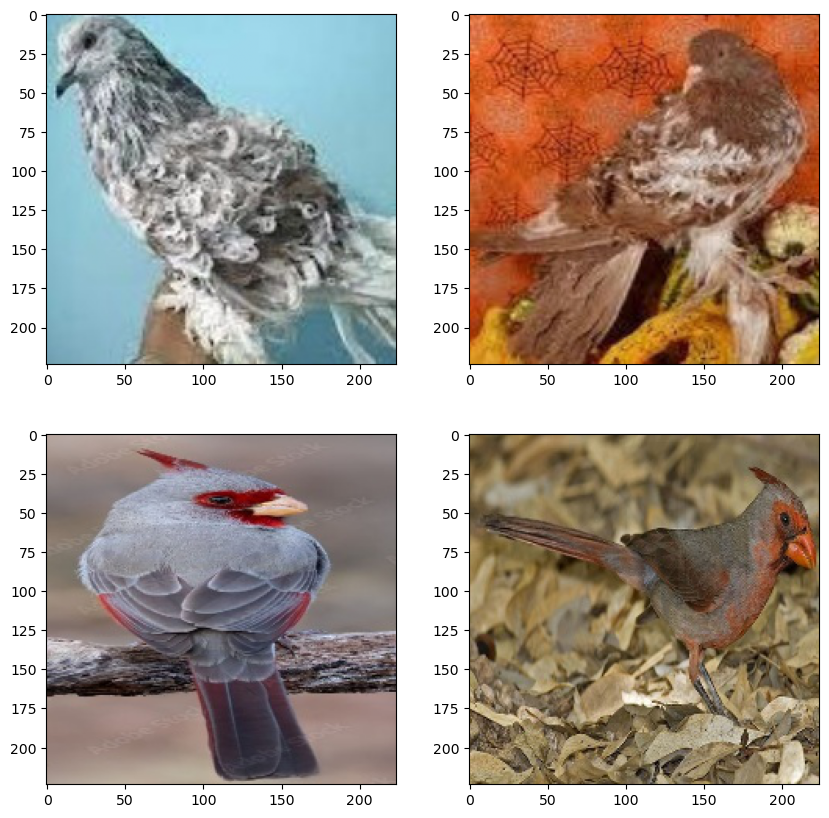

In [9]:
i = 23
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(X_train[i])
plt.subplot(222), plt.imshow(X_train[i+25])
plt.subplot(223), plt.imshow(X_train[i+50])
plt.subplot(224), plt.imshow(X_train[i+75])

In [8]:
### Function to plot our model training results
def plot_model_training(history):
    """
    Function to print result of epoch fit when training a CNN model.
    :param [history]: Each result of each Epochs during training
    :type [history]: keras history object
    
    ...
    :return: Plot of the training and validation results for accuracy and loss function.
    :rtype: Matplotlib plot   
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label = 'Training Acc')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()




## Base model

In [9]:
### Definition of the callbacks function when fitting the model
early_stopping = EarlyStopping(monitor="val_loss"
                               ,patience=10
                               ,verbose=1
                               ,restore_best_weights=True)

c:\Users\AlexandraLandry\Documents\GitHub\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,223 (1.76 MB)

 Trainable params: 462,223 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


c:\Users\AlexandraLandry\Documents\GitHub\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.1151 - loss: 2.5762 - val_accuracy: 0.3600 - val_loss: 2.0550
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.3191 - loss: 1.9689 - val_accuracy: 0.4400 - val_loss: 1.7656
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 57s 550ms/step - accuracy: 0.4399 - loss: 1.6249 - val_accuracy: 0.5067 - val_loss: 1.5826
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 3408s 33s/step - accuracy: 0.5115 - loss: 1.4369 - val_accuracy: 0.5067 - val_loss: 1.5182
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 282ms/step - accuracy: 0.5641 - loss: 1.2808 - val_accuracy: 0.6267 - val_loss: 1.3402
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.6798 - loss: 1.0036 - val_accuracy: 0.6133 - val_loss: 1.2305
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 0.7323 - loss: 0.8152 - val_accuracy: 0.6267 - val_loss: 1.1039
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 0.7753 - loss: 0.6879 - val_a

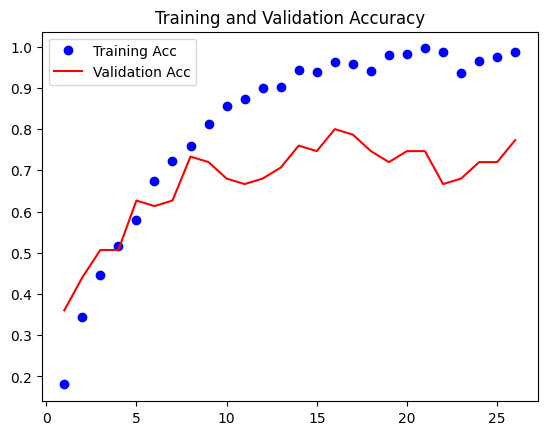

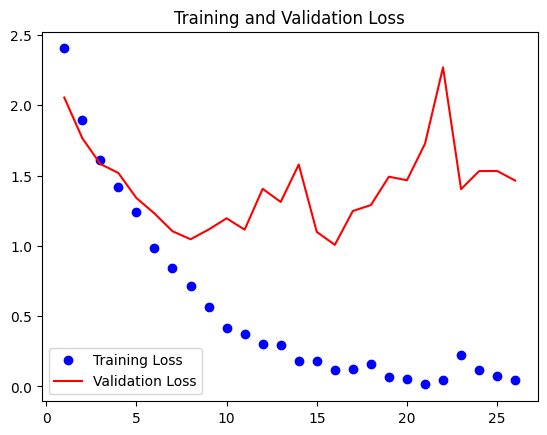

Test loss: 0.8631170392036438
Test accuracy: 0.8399999737739563


In [12]:
### The base model

## Building the CNN model
model1 = keras.Sequential()

model1.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Flatten())

model1.add(Dense(256, activation='relu'))

model1.add(Dense(15, activation='softmax'))

## Compiling the model
model1.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

## Printing the summary of the model
model1.summary()

## Fitting the model
epochs = 30

history1 = model1.fit(X_train, y_train
                      ,batch_size=32
                      ,validation_data=[X_valid, y_valid]
                      ,epochs=epochs
                      ,callbacks=[early_stopping])

## Plot for the training results
plot_model_training(history1)

## Evaluating the model on unseen data with the test data
score1 = model1.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score1[0])
print("Test accuracy:", score1[1])


In [13]:
# Saving the model:
model1.save('base_model.keras')

## Augmented model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       7

C:\Users\lotrh\anaconda3\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


104/104 [==============================] - 112s 1s/step - loss: 5.0618 - accuracy: 0.3315 - val_loss: 3.0300 - val_accuracy: 0.0800 - lr: 0.0010
Epoch 2/30
104/104 [==============================] - 108s 1s/step - loss: 2.2278 - accuracy: 0.4864 - val_loss: 2.7632 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 3/30
104/104 [==============================] - 110s 1s/step - loss: 1.9790 - accuracy: 0.5844 - val_loss: 2.4769 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 4/30
104/104 [==============================] - 108s 1s/step - loss: 1.8756 - accuracy: 0.6425 - val_loss: 2.5855 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 5/30
104/104 [==============================] - 111s 1s/step - loss: 1.6713 - accuracy: 0.6930 - val_loss: 1.6906 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 6/30
104/104 [==============================] - 109s 1s/step - loss: 1.5474 - accuracy: 0.7232 - val_loss: 2.7253 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 7/30
104/104 [==============================] - ETA: 0s - loss: 1.522

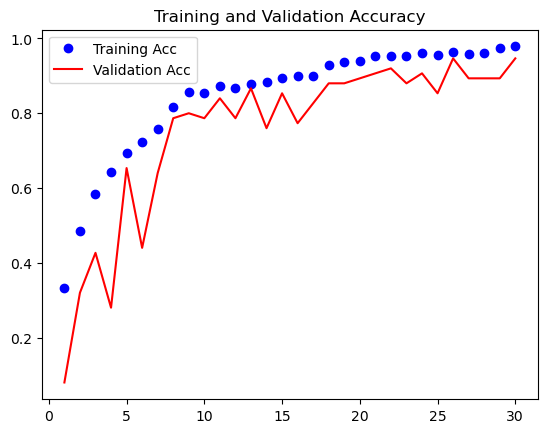

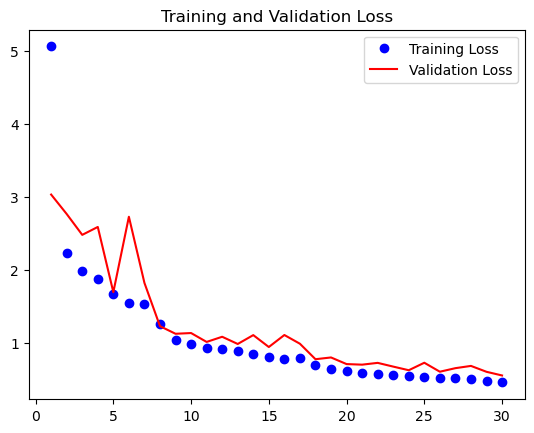

Test loss: 0.5730395317077637
Test accuracy: 0.8933333158493042


In [11]:
### After testing numerous models, this is the best model we could come up with manually.
rlronp = tf.keras.callbacks.ReduceLROnPlateau(montitor='val_loss',factor=0.4,patience=2,verbose=1)
early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,verbose=1,restore_best_weights=True)

## Building the CNN model
model2 = keras.Sequential()

# Data augmentation
model2.add(layers.RandomFlip(mode='horizontal_and_vertical',input_shape=(224,224,3)))

model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2), padding='same'))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2), padding='same'))

model2.add(Conv2D(128,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2), padding='same'))

model2.add(Conv2D(256,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2), padding='same'))

model2.add(Conv2D(256,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2), padding='same'))

model2.add(layers.BatchNormalization())

model2.add(Flatten())

model2.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.016),activity_regularizer=regularizers.l1(0.006),
                      bias_regularizer=regularizers.l1(0.006),activation='relu'))

model2.add(layers.Dropout(0.20))

model2.add(Dense(15,activation='softmax'))

## Compiling the model
model2.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

## Printing the summary of the model
model2.summary()

## Fitting the model
epochs=30
history2 = model2.fit(X_train, y_train
                    ,batch_size=32
                    ,validation_data=[X_valid, y_valid]
                    ,epochs=epochs
                    ,callbacks=[rlronp, early_stopping2])

## Plot for the training results
plot_model_training(history2)

## Evaluating the model on unseen data with the test data
score2 = model2.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

In [12]:
# Saving the model:
model2.save('augmented_model.keras')

In [14]:
augmented_model_history=pd.DataFrame(history2.history)
augmented_model_history.to_csv('augmented_model_history.csv')

## Pretrained models

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,383 (56.16 MB)

 Trainable params: 7,695 (30.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.3513 - loss: 2.1465 - val_accuracy: 0.7733 - val_loss: 1.0107
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7634 - loss: 0.8962 - val_accuracy: 0.8667 - val_loss: 0.6758
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.8337 - loss: 0.6847 - val_accuracy: 0.8533 - val_loss: 0.5938
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.8579 - loss: 0.5502 - val_accuracy: 0.8400 - val_loss: 0.5360
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.8676 - loss: 0.4928 - val_accuracy: 0.9067 - val_loss: 0.4190
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.8970 - loss: 0.4092 - val_accuracy: 0.8933 - val_loss: 0.3773
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.9051 - loss: 0.3755 - val_accuracy: 0.8667 - val_loss: 0.3890
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9106 - loss: 0.3400 - val_accu

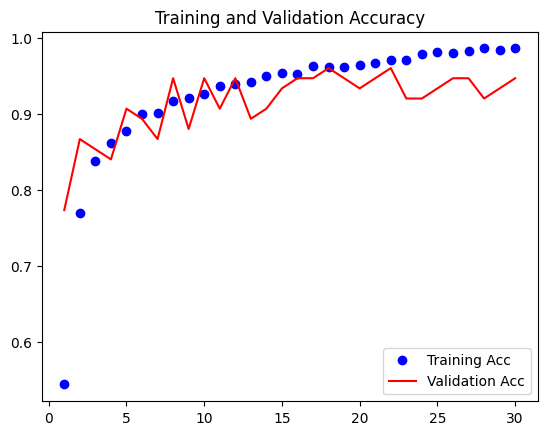

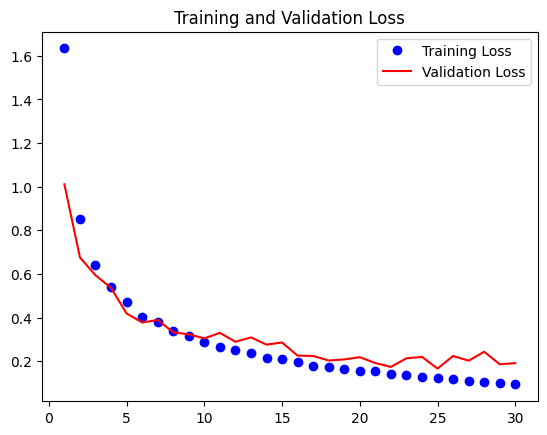

Test loss: 0.13346274197101593
Test accuracy: 0.9599999785423279


In [16]:
### Testing pretrained model -- VGG16

## Building the CNN model
# VGG16 pretrained model
base_model_vgg = VGG16(include_top = False, input_shape = (224, 224, 3))
base_model_vgg.trainable = False

# Define the hidden layers and the output
x = base_model_vgg.get_layer('block5_pool').output
x = layers.GlobalAveragePooling2D()(x) 
outputs = layers.Dense(15, activation = 'softmax')(x)

# Create the model
model_vgg = models.Model(base_model_vgg.input, outputs)

## Compiling the model
model_vgg.compile(loss = 'sparse_categorical_crossentropy'
             ,optimizer = optimizers.Adam(learning_rate = 0.01)
             ,metrics = ['accuracy'])

## Printing the summary of the model
model_vgg.summary()

## Fitting the model
epochs=30
history_vgg = model_vgg.fit(X_train, y_train
         ,epochs = epochs
         ,validation_data = [X_valid, y_valid]
         ,batch_size=32
         ,callbacks=[early_stopping])

## Plot for the training results
plot_model_training(history_vgg)

## Evaluating the model on unseen data with the test data
score_vgg = model_vgg.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score_vgg[0])
print("Test accuracy:", score_vgg[1])

# Part of the code from: https://medium.com/@bobbycxy/birds-classification-with-pre-trained-convolutional-neural-networks-and-cam-heatmap-visualization-3d424423aaa4

In [25]:
# Saving the model:
model_vgg.save('model_vgg.keras')


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 95s 734ms/step - accuracy: 0.4547 - loss: 5.2678 - val_accuracy: 0.8667 - val_loss: 0.4316
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 558ms/step - accuracy: 0.8119 - loss: 0.7646 - val_accuracy: 0.9200 - val_loss: 0.2869
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 59s 549ms/step - accuracy: 0.8390 - loss: 0.7607 - val_accuracy: 0.9467 - val_loss: 0.1700
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 590ms/step - accuracy: 0.8485 - loss: 0.8379 - val_accuracy: 0.8400 - val_loss: 0.6779
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 569ms/step - accuracy: 0.8363 - loss: 0.9448 - val_accuracy: 0.9067 - val_loss: 0.2401
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 568ms/step - accuracy: 0.8839 - loss: 0.6454 - val_accuracy: 0.8400 - val_loss: 0.8091
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 566ms/step - accuracy: 0.8686 - loss: 0.7890 - val_accuracy: 0.9067 - val_loss: 0.5396
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 61s 561ms/step - accuracy: 0.8955 - loss: 0

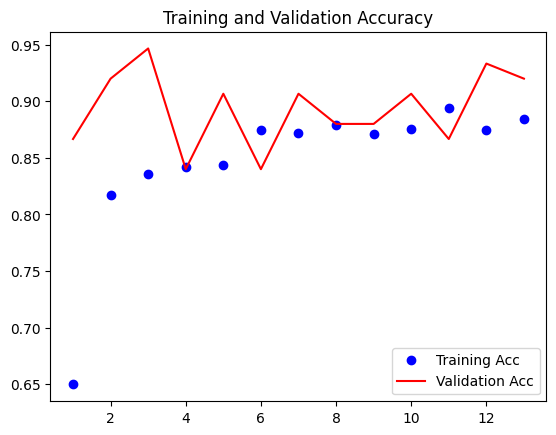

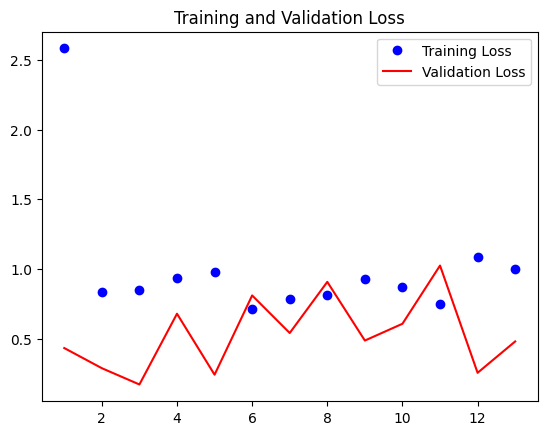

Test loss: 0.13088424503803253
Test accuracy: 0.9599999785423279


In [11]:
### Testing pretrained model -- InterceptV3 with data augmentation

## Building the CNN model
# InterceptV3 pretrained model
base_model = InceptionV3(include_top = False, input_shape = (224, 224, 3))
base_model.trainable = False

# Define the hidden layers and output layer
x = base_model.get_layer('mixed10').output
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(15, activation = 'softmax')(x)

# Create the model
model_interV3 = models.Model(base_model.input, outputs)

## Compiling the model
model_interV3.compile(loss = 'sparse_categorical_crossentropy'
             ,optimizer = optimizers.Adam(learning_rate = 0.01)
             ,metrics = ['accuracy'])

## Printing the summary of the model
#model_interV3.summary() Very long model to print
             
## Data augmentation
datagen2 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

train_generator = datagen2.flow(X_train, y_train, batch_size=32)

## Fitting the model
history_interV3 = model_interV3.fit(train_generator
         ,epochs = 30
         ,validation_data = [X_valid, y_valid]
         ,batch_size=32
         ,callbacks=[early_stopping])

## Plot for the training results
plot_model_training(history_interV3)

## Evaluating the model on unseen data with the test data
score_interV3 = model_interV3.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score_interV3[0])
print("Test accuracy:", score_interV3[1])

# Part of the code from: https://medium.com/@bobbycxy/birds-classification-with-pre-trained-convolutional-neural-networks-and-cam-heatmap-visualization-3d424423aaa4

In [18]:
# Saving the model:
model_interV3.save('model_interceptV3.keras')

In [ ]:
### Ressources

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# https://stackoverflow.com/questions/46036522/defining-model-in-keras-include-top-true
# https://keras.io/guides/transfer_learning/
# https://medium.com/@bobbycxy/birds-classification-with-pre-trained-convolutional-neural-networks-and-cam-heatmap-visualization-3d424423aaa4
# https://stackoverflow.com/questions/73845849/is-my-cnn-model-still-overfitting-if-so-how-can-i-combat-it-is-there-somethin
